# Order Fulfilment Analysis: Analyse order_items.csv and orders.csv to understand order fulfilment timelines and status.

In [295]:
order_items = pd.read_csv('./data/order_items.csv')
orders = pd.read_csv('./data/orders.csv')


In [243]:
print(order_items.shape)
print(orders.shape)

(181759, 11)
(125226, 9)


In [244]:
orders.head()

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
0,8,5,Cancelled,F,2022-10-20 10:03:00+00:00,NaN,NaN,NaN,3
1,60,44,Cancelled,F,2023-01-20 02:12:00+00:00,NaN,NaN,NaN,1
2,64,46,Cancelled,F,2021-12-06 09:11:00+00:00,NaN,NaN,NaN,1
3,89,65,Cancelled,F,2020-08-13 09:58:00+00:00,NaN,NaN,NaN,1
4,102,76,Cancelled,F,2023-01-17 08:17:00+00:00,NaN,NaN,NaN,2


In [245]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125226 entries, 0 to 125225
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   order_id      125226 non-null  int64 
 1   user_id       125226 non-null  int64 
 2   status        125226 non-null  object
 3   gender        125226 non-null  object
 4   created_at    125226 non-null  object
 5   returned_at   12530 non-null   object
 6   shipped_at    81461 non-null   object
 7   delivered_at  43884 non-null   object
 8   num_of_item   125226 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 8.6+ MB


In [246]:
orders.isnull().sum() * 100 / len(orders)

order_id         0.000000
user_id          0.000000
status           0.000000
gender           0.000000
created_at       0.000000
returned_at     89.994091
shipped_at      34.948813
delivered_at    64.956159
num_of_item      0.000000
dtype: float64

In [247]:
orders.drop(['returned_at','shipped_at','delivered_at'],axis = 1,inplace = True)

## Analysing the order_items data - already done in the first part

## Analysing orders data

In [248]:
orders['status'].value_counts(normalize = True)

Shipped       0.300073
Complete      0.250379
Processing    0.200885
Cancelled     0.148603
Returned      0.100059
Name: status, dtype: float64

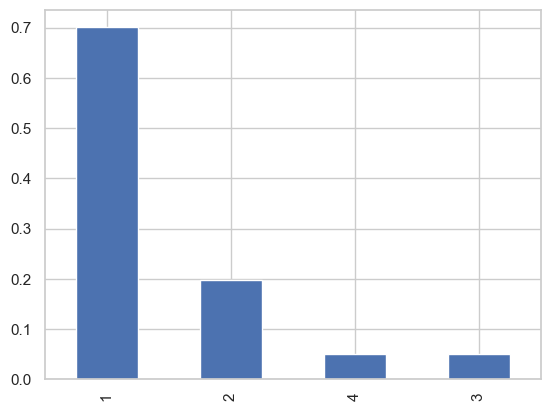

In [256]:
orders['num_of_item'].value_counts(normalize = True).plot(kind = 'bar')
plt.show()

### Most of the order has only 1 item (70%)

In [258]:
orders_merged_df = pd.merge(order_items, orders, on=['order_id', 'user_id'], how='inner')

In [260]:
orders_merged_df.head(3)

,id,order_id,user_id,product_id,inventory_item_id,status_x,created_at_x,shipped_at,delivered_at,returned_at,sale_price,status_y,gender,created_at_y,num_of_item
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaN,NaN,NaN,0.02,Cancelled,F,2023-05-07 07:33:00+00:00,1
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaN,0.02,Complete,F,2023-03-14 03:59:00+00:00,1
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaN,0.02,Complete,F,2023-12-03 13:23:00+00:00,4


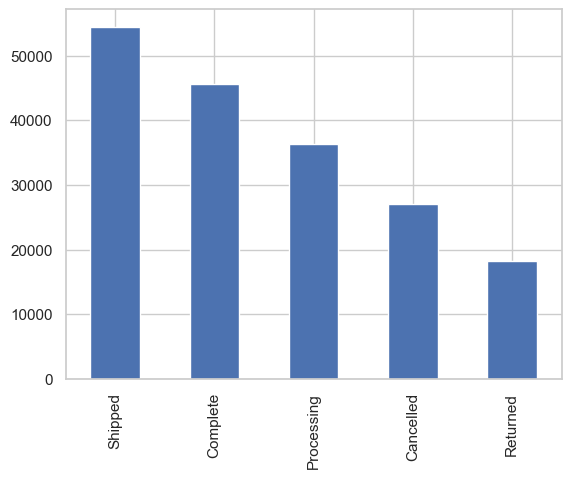

In [265]:
orders_merged_df['status_x'].value_counts().plot(kind = 'bar')
plt.show()

In [269]:
orders_merged_df['sale_price'].describe()

count    181759.000000
mean         59.568544
std          66.657262
min           0.020000
25%          24.500000
50%          39.990002
75%          69.949997
max         999.000000
Name: sale_price, dtype: float64

In [274]:
orders_merged_df['gender'].value_counts()

F    91009
M    90750
Name: gender, dtype: int64

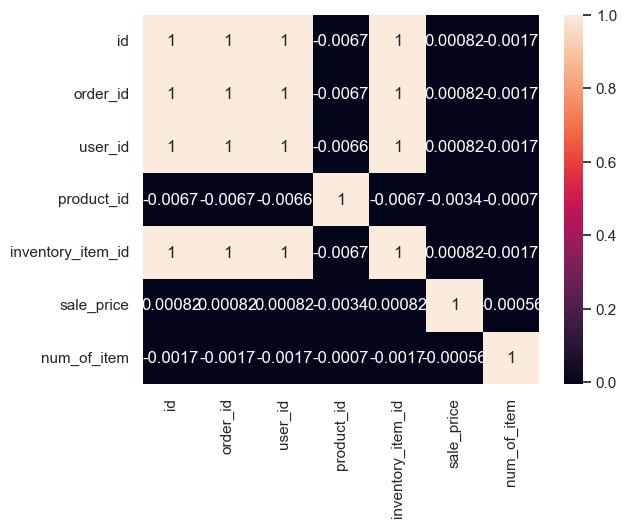

In [275]:
sns.heatmap(orders_merged_df.corr(),annot = True)
plt.show()

In [280]:
timestamp_columns = ['created_at_x', 'shipped_at', 'delivered_at', 'returned_at', 'created_at_y']
orders_merged_df[timestamp_columns] = orders_merged_df[timestamp_columns].apply(pd.to_datetime)

orders_merged_df['shipping_duration'] = orders_merged_df['shipped_at'] - orders_merged_df['created_at_x']
orders_merged_df['delivery_duration'] = orders_merged_df['delivered_at'] - orders_merged_df['shipped_at']

# Calculate return duration if needed
orders_merged_df['return_duration'] = orders_merged_df['returned_at'] - orders_merged_df['delivered_at']

# Print mean shipping, delivery, and return durations
print("Mean Shipping Duration:", orders_merged_df['shipping_duration'].mean())
print("Mean Delivery Duration:", orders_merged_df['delivery_duration'].mean())
print("Mean Return Duration:", orders_merged_df['return_duration'].mean())


Mean Shipping Duration: 0 days 12:56:24.119207649
Mean Delivery Duration: 2 days 12:17:41.406306292
Mean Return Duration: 1 days 12:01:12.327775340


#### Mean Shipping Duration: 0 days 12:56:24.119207649
#### Mean Delivery Duration: 2 days 12:17:41.406306292
#### Mean Return Duration: 1 days 12:01:12.327775340

In [344]:
orders_merged_df_product = pd.merge(orders_merged_df, product, left_on=['product_id'],right_on=['id'], how='inner')

frequent_products = orders_merged_df_product['product_id'].value_counts().tolist()

freq = []
n = 10
i = 0
while (n>0):
    if frequent_products[i] not in freq:
        freq.append(frequent_products[i])
        n -= 1
    i += 1

In [347]:
product[product['id'].isin(freq)][['name','category']]

,name,category
645,Hurley Sun Also Sets T-Shirt - Short-Sleeve - ...,Tops & Tees
6516,Alternative Women's Florence Wrap,Tops & Tees
10720,Jones New York Women's Pleated Round Neck Blouse,Tops & Tees
10721,Jones New York Women's Petite 3/4 Sleeve Blouse,Tops & Tees
12508,Volcom Juniors Pocket Blocket Long Sleeve Tee,Tops & Tees
15115,2B Paradise Breeze Button Down Tank,Tops & Tees
15350,Lucky Brand Women's Plus-Size Jane Scarf Blouse,Tops & Tees
15351,Lucky Brand Women's Plus-Size Moroccan Medalli...,Tops & Tees
24043,Calvin Klein Jeans Women's Embellished Stripe ...,Tops & Tees
26079,Billabong Aussies T-Shirt - Short-Sleeve - Wom...,Tops & Tees


## These are top products